In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [465]:
class Tree:
    def __init__(self, w=0, f_index=0, root=None, 
        left_c=None, right_c=None, f_type=0, cat_class=None, class_type=None):
        self.root = root
        self.left = left_c
        self.right = right_c
        self.w = w
        self.ftype = f_type # 0 - numbs, 1 - categs
        if self.ftype and cat_class is None:
            raise "cat_class hasn't been passed"
        self.cat_class = cat_class
        self.f_index = f_index
        self.class_type = class_type

    def __str__(self):
        st = f"Root: {self.root}, w: {self.w}, f_index: {self.f_index}"
        if self.left is not None:
            st += f", left: {self.left.f_index}"
        if self.right is not None:
            st += f", right: {self.right.f_index}"
        return st

    def _move(self, x):
        if x[self.f_index] <= self.w:
            if self.left is None:
                return self.class_type, None
            return None, self.left
        else:
            if self.right is None:
                return self.class_type, None
            return None, self.right

    def move(self, X):
        y = []
        for xi in X:
            res = None
            node = self
            while res is None:
                res, node = node._move(xi)
            y.append(res)
        return np.array(y)


    def set_root(self, root, lorr=0):
        if root is not self:
            self.root = root
        if self.root is not None:
            if lorr:
                self.root.right = self
            else:
                self.root.left = self

    def set_left(self, l):
        self.left = l
        self.left.root = self
    
    def set_right(self, r):
        self.right = r
        self.right.root = self

    def set_both(self, l, r):
        self.set_left(l)
        self.set_right(r)
                    

In [498]:
class DecisionTree(torch.nn.Module):
    """DecisionTree with ID3 algorithm"""
    def __init__(self, *args, **kwargs):
        super(DecisionTree, self).__init__(*args, **kwargs)
        self.tree = None

    def train(self, X, Y, md=3):
        # type train
        if self.tree is not None:
            del self.tree
            self.tree = None
        rec_list = [(None, X, Y, -1)]
        count = 0
        while len(rec_list) != 0 and count < md:
            
            count += 1
            x = rec_list[0][1]
            y = rec_list[0][2]
            node = None
            splits = None
            h = self.H(y)
            if h == 0:
                if len(y):
                    node = Tree(class_type=y[0])
                else:
                    node = Tree(class_type=0)
            else:
                bi, bv = self.find_best_feature(x, y)
                node = Tree(w=bv, f_index=bi, class_type=self.max_prob(rec_list[0][2]))
                splits = self.split(rec_list[0][1], rec_list[0][2], bi, bv)
            node.set_root(rec_list[0][0], rec_list[0][3])
            if self.tree is None:
                self.tree = node
            if splits is not None and len(splits[2]):
                rec_list.append((node, splits[0], splits[2], 0))
            if splits is not None and len(splits[3]):
                rec_list.append((node, splits[1], splits[3], 1))
            rec_list.pop(0)
                
    def max_prob(self, Y):
        classes = np.bincount(Y)
        prob = classes[np.nonzero(classes)]/len(Y)
        maxp = 0
        maxp_i = 0
        for i, yi in enumerate(prob):  
            if yi > maxp:
                maxp = yi
                maxp_i = i
        return maxp_i      

    def predict(self, X):
        if self.tree is None:
            return None
        return self.tree.move(X)

    def find_best_feature(self, X, Y):
        best_index = 0
        best_ig = 0
        best_val = X[0,0]
        for xi in range(X.shape[1]):
            val, ig = self.find_best_split(X,Y,xi,ftype=0)
            # print(f"findex: {xi}, val: {val}, IG: {ig}")
            if ig > best_ig:
                best_ig = ig
                best_index = xi
                best_val = val
        return best_index, best_val

    def find_best_split(self, X, Y, f_index, ftype=0):
        split_vals = np.unique(X[:,f_index])
        bf_index = 0
        bf_val = split_vals[bf_index]
        bf_ig = 0
        for i, xi in enumerate(split_vals):
            xl, xr, yl, yr = self.split(X,Y, f_index, xi, ftype)
            ig = self.IG([yl, yr], Y)
            # print(f"atr_index: {xi}, IG: {ig}")
            if ig > bf_ig:
                bf_ig = ig
                bf_val = xi
                bf_index = i
        return bf_val, bf_ig

    @staticmethod
    def split(X,Y, f_index, f_val, ftype=0):
        x_l = None
        x_r = None
        y_l = None
        y_r = None
        if ftype:
            b = X[:, f_index] == f_val
            x_l = X[b]
            x_r = X[~b]
            y_l = Y[b]
            y_r = Y[~b]
        else:
            b = X[:, f_index] <= f_val
            x_l = X[b]
            x_r = X[~b]
            y_l = Y[b]
            y_r = Y[~b]
            
        return x_l, x_r, y_l, y_r

    @staticmethod
    def H_(Y):
        if (len(Y) <= 1):
            return 0
        classes = np.bincount(Y)
        prob = classes[np.nonzero(classes)]/len(Y)
        if (len(prob) <= 1):
            return 0
        return -np.sum(prob*np.log(prob))

    @staticmethod
    def H(Y):
        """Entropy function"""
        return DecisionTree.H_(Y)/np.log(2)

    @staticmethod
    def Hn(Y):
        classes = np.bincount(Y)
        prob = classes[np.nonzero(classes)]/len(Y)
        return DecisionTree.H(Y)*np.log(2)/np.log(len(prob))

    @staticmethod
    def IG(Y_splits, Y_prev, h=DecisionTree.H):
        """Information Gain function"""
        cond_H = sum([h(y)*len(y)/len(Y_prev) for y in Y_splits])
        return h(Y_prev) - cond_H



In [485]:
A = np.arange(0,100,1).reshape(50, 2)
B = np.array([0,0,1,1,0,2])
c = np.bincount(B)
# B[np.nonzero()]
c[np.nonzero(c)]/len(B)

array([0.5       , 0.33333333, 0.16666667])

In [499]:
dt = DecisionTree()
py = np.array([0,0,0,1,1,1,2,3])
sy = [np.array([0,0,1,1,1]), np.array([2,3,0])]
dt.IG(sy, py)
# dt.H(py) - (dt.H(sy[0])*len(sy[0])/len(py) + dt.H(sy[1])*len(sy[1])/len(py))

dt.Hn(sy[1])

0.9999999999999998

In [500]:
A = np.random.randint(0,100, 100).reshape(25,4)
Y = np.random.randint(0,3, 25)

In [511]:
fi, ig = dt.find_best_feature(A,Y)
# print(A, Y)
xtr, xte, ytr, yte = A[:20], A[20:], Y[:20], Y[20:]
dt.train(xtr, ytr, 13)
print(dt.tree)

# print(dt.tree.left)
# print(dt.tree.right)
# print(dt.tree.left.left)
# print(dt.tree.left.right)
# print(dt.tree.right)

Root: None, w: 6, f_index: 0, left: 0, right: 0


In [513]:
yp = dt.predict(xtr)
ypte = dt.predict(xte)
print("tac: ",sum(yp == ytr)/len(ytr) * 100)
print("test ac: ", sum(ypte == yte)/len(yte) * 100)


tac:  95.0
test ac:  40.0


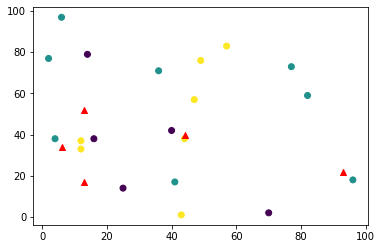

In [523]:
plt.scatter(xtr[:,0], xtr[:,1], c=ytr)
plt.scatter(xte[:,0], xte[:,1], marker='^', c='r')
plt.savefig("DecisionTree_on_random_data_train_test_datas.png", dpi=150)

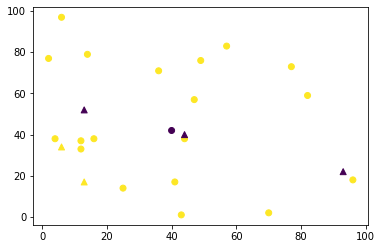

In [525]:

plt.scatter(xtr[:,0], xtr[:,1], c=(yp==ytr))
plt.scatter(xte[:,0], xte[:,1], marker='^', c=(ypte==yte))

plt.savefig("DecisionTree_on_random_data_train_test_acc.png", dpi=150)